# Measurement uncertainty calculations

## Definitions
**Measurement uncertainty** is defined in the ISO ‘Guide to the Expression of Uncertainty in Measurement’ as ‘a parameter, associated with the result of a measurement that characterises the dispersion of the values that  could  reasonably  be  attributed  to  the  measurand’.  The  **measurand**  is  the  ‘quantity  intended  to  be measured’.

## Purpose
An  estimate  of  uncertainty  provides  a  quantitative  indication  of  the  quality  of  a  measurement  result. Rather than using a ‘bottom-up’ approach which examines the inputs to a method and considers how they might influence results, the biochemical genetics units uses a ‘top-down’ approach using the information from method outputs (e.g. the observed variability of replicate measurement results), as described in ADD.BIO 6680: Estimating measurement uncertainty in the biochemical genetics unit. This notebook attempts to outline these steps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Since some columns have long names, change the maximum column width in Pandas so I can see the full name.

In [2]:
pd.set_option('display.max_colwidth', -1)

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import name of assays, measurands and performance targets

The name of the assay, measurand and performance targets for each measurand are detailed in **ADD.BIO 6378**: *BGU Quality Monitoring Processes (Appendix 4)*

In [46]:
def import_performance_targets(filename):
    performance_targets = pd.read_excel(filename,skiprows=2
                                       ,names=['Assay','Measurand','Biol CVi','Biol CVg'
                                               ,'Anal CV Optimal','Anal CV Desirable','Anal CV Minimal'
                                              ,'Bias Optimal','Bias Desirable','Bias Minimal'
                                              ,'TE Optimal','TE Desirable','TE Minimal','Source of performance targets'])
    performance_targets = performance_targets.drop(columns=['Biol CVi','Biol CVg','Source of performance targets'])
    return performance_targets.round(1)

In [71]:
performance_targets = import_performance_targets("Measurement uncertainty performance targets December 2020.xlsx")
performance_targets

,Assay,Measurand,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal
0,Amino acids (CSF),Glycine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
1,Amino acids (CSF),Serine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
2,Amino acids (Plasma),Alanine,3.7,7.4,11.0,7.2,14.4,21.6,13.3,26.6,39.8
3,Amino acids (Plasma),Arginine,4.8,9.6,14.5,4.9,9.8,14.7,12.9,25.7,38.6
4,Amino acids (Plasma),Aspartic acid,7.8,15.6,23.4,7.9,15.8,23.7,20.8,41.6,62.4
5,Amino acids (Plasma),Citrulline,5.4,10.7,16.0,6.1,12.2,18.3,14.9,29.9,44.8
6,Amino acids (Plasma),Glutamic acid,11.6,23.2,34.8,11.5,23.1,34.6,30.7,61.4,92.1
7,Amino acids (Plasma),Glutamine,3.0,6.0,9.1,3.1,6.3,9.4,8.1,16.3,24.4
8,Amino acids (Plasma),Glycine,3.0,5.9,8.9,5.2,10.5,15.7,10.1,20.2,30.3
9,Amino acids (Plasma),Histidine,2.4,4.8,7.3,3.6,7.2,10.8,7.6,15.2,22.8


The mappings file contains mappings to link the Assay and Measurand to the name of the QC material in [Randox Acusera 24:7](https://qc.randox.com/Acusera#Home)

In [7]:
mappings = pd.read_csv('mappings.csv')
mappings.head()

,Assay,Measurand,Randox
0,Amino acids (CSF),Glycine,NaN
1,Amino acids (CSF),Serine,NaN
2,Amino acids (Plasma),Alanine,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom
3,Amino acids (Plasma),Alloisoleucine,Alloisoleucine Clinical Chemistry Cation exchange chromatography umol/l Biochrom
4,Amino acids (Plasma),Arginine,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom


In [8]:
df = mappings.merge(right=performance_targets,how='outer', on=['Assay','Measurand'],copy=False)

Find out which measurands do not have any QC data - these are mainly calculated values (which will be dealt with later)

In [9]:
df[df['Randox'].isnull()]

,Assay,Measurand,Randox,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal
0,Amino acids (CSF),Glycine,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
1,Amino acids (CSF),Serine,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
47,Amino acids (Urine),Alanine/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
48,Amino acids (Urine),Arginine/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
49,Amino acids (Urine),Aspartic acid/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
50,Amino acids (Urine),Citrulline/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
51,Amino acids (Urine),Cystine/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
52,Amino acids (Urine),Glutamic acid/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
53,Amino acids (Urine),Glutamine/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500
54,Amino acids (Urine),Glycine/creatinine ratio,NaN,5.00,10.0,15.00,5.0,10.0,15.0,13.2500,26.500,39.7500


### Import measurement uncertainty report from Randox Acusera 24:7

In [83]:
def import_randox(filename, mappings):
    '''
    Imports measurement uncertainty excel file from Randox Acusera, then
    maps these to the Assay and Measurands via the Mappings file
    '''
    randoxMU = pd.read_excel(filename)
    randoxMU = randoxMU.rename(columns={'Assay':'Randox'})
    randoxMU = randoxMU.drop(columns=['Intra','Inter','ExpandedUOM'])
    randoxMU = randoxMU.sort_values(by=['Randox','Mean'])
    randoxMU['% CV'] = round(randoxMU['UOM']/randoxMU['Mean'] * 100,1)
    
    ## Urine, Plasma and CSF QCs are all stored in Randox under the same name.
    ## Add an extra note in the Randox column for urine QC to distinguish these,
    ## identified by the lot number starting with "AAU"
    randoxMU['Randox'][randoxMU['Lot Name'].str[:3] == 'AAU'] = randoxMU['Randox'].astype(str) + ' (Urine)'
    
    ## Read the mappings csv file and join this with the QC data to show the Assay and Measurand name
    mappings = pd.read_csv('mappings.csv')
    qc_data = mappings.merge(right=randoxMU,on='Randox',how='inner')
    
    return qc_data

In [84]:
qc_data = import_randox("Uncertainty of Measurement.xlsx","mappings.csv")

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [85]:
qc_data.head()

,Assay,Measurand,Randox,Instrument,Lot Name,Count,Mean,UOM,% CV
0,Amino acids (Plasma),Alanine,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,AAA+,AA2019.1571,52,324.173,10.525,3.2
1,Amino acids (Plasma),Alanine,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,AAA+,AA2019.1572,52,933.115,35.659,3.8
2,Amino acids (Plasma),Alloisoleucine,Alloisoleucine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,AAA+,AAA_200401,48,76.562,2.492,3.3
3,Amino acids (Plasma),Arginine,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,AAA+,AA2019.1571,52,25.346,1.909,7.5
4,Amino acids (Plasma),Arginine,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,AAA+,AA2019.1572,52,514.731,17.448,3.4


## QC statistics

Create a summary for each lot number that shows some basic statistics

In [86]:
def qc_lot_summary(qc_data, assay):
    '''
    Returns a dataframe containing lot number statistics for the assay QC data
    '''
    ## Define the order in which columns should appear
    column_order = ['Count','Mean','UOM','% CV']
    
    ## Filter the main qc data file for only the assay we are interested in, and drop unnecessary columns
    assay_qc_data = qc_data[qc_data['Assay'] == assay].drop(columns=['Assay','Randox','Instrument'])
    
    ## Round the data to 1 decimal place
    assay_qc_data = assay_qc_data.round(1)
    
    ## Pivot the data so that lot number appears a column (and swap levels so that lot no is the first level)
    assay_qc_pivot = assay_qc_data.pivot(index='Measurand', values=column_order, columns='Lot Name')
    assay_qc_pivot = assay_qc_pivot.swaplevel(0,1, axis=1).sort_index(axis=1)

    ## Reorder columns and fill blanks
    assay_qc_pivot = assay_qc_pivot.reindex(column_order, level=1, axis=1)
    assay_qc_pivot = assay_qc_pivot.fillna('')
    
    return assay_qc_pivot

In [87]:
qc_lot_summary(qc_data,'Amino acids (Plasma)')

Lot Name       AA2019.1571                    AA2019.1572                     \
                     Count   Mean   UOM  % CV       Count    Mean   UOM % CV   
Measurand                                                                      
Alanine         52          324.2  10.5  3.2   52          933.1   35.7  3.8   
Alloisoleucine                                                                 
Arginine        52          25.3   1.9   7.5   52          514.7   17.4  3.4   
Aspartic acid   52          18.5   1     5.6   50          87      4.7   5.4   
Citrulline      52          21.1   1.2   5.8   51          412.6   17.7  4.3   
Glutamic acid   52          57.6   4.3   7.5   51          243.1   14.8  6.1   
Glutamine       52          571.7  25.7  4.5   52          1171.8  60.5  5.2   
Glycine         52          300.2  10.4  3.5   52          1042.6  44.2  4.2   
Histidine       52          99.6   3.8   3.8   52          393.2   17.3  4.4   
Isoleucine      59          30.7   2.1   7     59          405.6   14.6  3.6   
Leucine         59          83.8   2.7   3.3   59          888.3   29.5  3.3   
Lysine          52          76.7   3.1   4     52          491     21.4  4.4   
Methionine      59          10.1   1.2   12.1  58          256     13.7  5.3   
Ornithine       52          63     2.2   3.6   52          664.2   25.2  3.8   
Phenylalanine   57          76.6   3.2   4.2   59          967.8   34.6  3.6   
Proline         52          189.3  13.1  6.9   50          542.2   40.2  7.4   
Serine          52          56     2.3   4.1   52          453.4   15.8  3.5   
Taurine         52          52.7   3     5.7   51          425.3   18.9  4.4   
Threonine       52          100.8  3.4   3.3   52          406.9   14.7  3.6   
Tryptophan      50          136.1  8.1   6     50          307.9   18.2  5.9   
Tyrosine        59          49.1   2     4.1   59          920.7   34.9  3.8   
Valine          59          152.3  6.7   4.4   58          850.9   29.8  3.5   

Lot Name       AAA_200401                  
                    Count  Mean  UOM % CV  
Measurand                                  
Alanine                                    
Alloisoleucine  48         76.6  2.5  3.3  
Arginine                                   
Aspartic acid                              
Citrulline                                 
Glutamic acid                              
Glutamine                                  
Glycine                                    
Histidine                                  
Isoleucine                                 
Leucine                                    
Lysine                                     
Methionine                                 
Ornithine                                  
Phenylalanine                              
Proline                                    
Serine                                     
Taurine                                    
Threonine                                  
Tryptophan                                 
Tyrosine                                   
Valine

Aggregate the data over all lots numbers by summing the total counts and average the measurement uncertainty and %CV.

**Potential improvement**: only do this if the %CV are similar?

In [88]:
def qc_aggregated(qc_data, assay):
    '''
    Returns total number of QC datapoints for each analyte and average of each lot number measurement uncertainty and %CV
    '''
    filtered = qc_data[qc_data['Assay'] == assay].drop(columns=['Assay','Randox','Instrument'])
    aggregated = filtered.groupby('Measurand').agg({'Count':'sum',
                                              'UOM':'mean',
                                              '% CV':'mean'})
    return aggregated.round(1)

In [89]:
qc_aggregated(qc_summary,'Amino acids (Plasma)')

,Count,UOM,% CV
Measurand,,,
Alanine,104,23.1,3.5
Alloisoleucine,48,2.5,3.3
Arginine,104,9.7,5.4
Aspartic acid,102,2.9,5.5
Citrulline,103,9.5,5.0
Glutamic acid,103,9.5,6.8
Glutamine,104,43.1,4.8
Glycine,104,27.3,3.8
Histidine,104,10.6,4.1


In [90]:
def qc_lot_summary_with_means(qc_data, assay):
    '''
    Returns a dataframe containing both lot number statistics and aggregated statistics
    '''
    assay_qc_pivot = qc_lot_summary(qc_data, assay)
    aggregated = qc_aggregated(qc_data, assay)
    
    assay_qc_pivot[('Total','Count')] = aggregated['Count']
    assay_qc_pivot[('Total','UOM')] = aggregated['UOM']
    assay_qc_pivot[('Total','% CV')] = aggregated['% CV']
    
    return assay_qc_pivot.round(1)

In [91]:
qc_lot_summary_with_means(qc_summary, 'VMA and HVA (Urine)')

Lot Name   63431                  63432                 63451                  \
           Count  Mean  UOM % CV  Count  Mean  UOM % CV Count  Mean  UOM % CV   
Measurand                                                                       
Urine HVA  104.0  9.9   0.4  3.9  105.0  84.9  2.9  3.4  19.0  7.6   0.4  5.0   
Urine VMA  94.0   15.8  0.4  2.8  103.0  79.6  2.7  3.3  20.0  14.6  0.4  2.9   

Lot Name  63452                 Total            
          Count  Mean  UOM % CV Count  UOM % CV  
Measurand                                        
Urine HVA  19.0  83.5  2.9  3.5  247   1.6  4.0  
Urine VMA  20.0  77.1  2.5  3.2  237   1.5  3.0

In [95]:
qc_lot_summary_with_means = qc_lot_summary_with_means(qc_summary, 'Amino acids (Plasma)')

In [116]:
qc_lot_summary_with_means

Lot Name       AA2019.1571                    AA2019.1572                     \
                     Count   Mean   UOM  % CV       Count    Mean   UOM % CV   
Measurand                                                                      
Alanine         52          324.2  10.5  3.2   52          933.1   35.7  3.8   
Alloisoleucine                                                                 
Arginine        52          25.3   1.9   7.5   52          514.7   17.4  3.4   
Aspartic acid   52          18.5   1     5.6   50          87      4.7   5.4   
Citrulline      52          21.1   1.2   5.8   51          412.6   17.7  4.3   
Glutamic acid   52          57.6   4.3   7.5   51          243.1   14.8  6.1   
Glutamine       52          571.7  25.7  4.5   52          1171.8  60.5  5.2   
Glycine         52          300.2  10.4  3.5   52          1042.6  44.2  4.2   
Histidine       52          99.6   3.8   3.8   52          393.2   17.3  4.4   
Isoleucine      59          30.7   2.1   7     59          405.6   14.6  3.6   
Leucine         59          83.8   2.7   3.3   59          888.3   29.5  3.3   
Lysine          52          76.7   3.1   4     52          491     21.4  4.4   
Methionine      59          10.1   1.2   12.1  58          256     13.7  5.3   
Ornithine       52          63     2.2   3.6   52          664.2   25.2  3.8   
Phenylalanine   57          76.6   3.2   4.2   59          967.8   34.6  3.6   
Proline         52          189.3  13.1  6.9   50          542.2   40.2  7.4   
Serine          52          56     2.3   4.1   52          453.4   15.8  3.5   
Taurine         52          52.7   3     5.7   51          425.3   18.9  4.4   
Threonine       52          100.8  3.4   3.3   52          406.9   14.7  3.6   
Tryptophan      50          136.1  8.1   6     50          307.9   18.2  5.9   
Tyrosine        59          49.1   2     4.1   59          920.7   34.9  3.8   
Valine          59          152.3  6.7   4.4   58          850.9   29.8  3.5   

Lot Name       AAA_200401                 Total             
                    Count  Mean  UOM % CV Count   UOM % CV  
Measurand                                                   
Alanine                                    104   23.1  3.5  
Alloisoleucine  48         76.6  2.5  3.3  48    2.5   3.3  
Arginine                                   104   9.7   5.4  
Aspartic acid                              102   2.9   5.5  
Citrulline                                 103   9.5   5.0  
Glutamic acid                              103   9.5   6.8  
Glutamine                                  104   43.1  4.8  
Glycine                                    104   27.3  3.8  
Histidine                                  104   10.6  4.1  
Isoleucine                                 118   8.4   5.3  
Leucine                                    118   16.1  3.3  
Lysine                                     104   12.3  4.2  
Methionine                                 117   7.4   8.7  
Ornithine                                  104   13.7  3.7  
Phenylalanine                              116   18.9  3.9  
Proline                                    102   26.6  7.2  
Serine                                     104   9.0   3.8  
Taurine                                    103   11.0  5.1  
Threonine                                  104   9.1   3.4  
Tryptophan                                 100   13.2  6.0  
Tyrosine                                   118   18.5  4.0  
Valine                                     117   18.2  4.0

## EQA data

In [225]:
df = pd.read_csv('eqa_results.csv')

In [175]:
df.head()

,Analyte,Specimen,Pool,Result,Targ,Scheme name
0,Phenylalanine,209A,273,137,142.1,Quantitative Amino Acids
1,Phenylalanine,209B,274,1373,1314.0,Quantitative Amino Acids
2,Phenylalanine,209C,275,960,911.3,Quantitative Amino Acids
3,Tyrosine,209A,273,99,101.8,Quantitative Amino Acids
4,Tyrosine,209B,274,202,197.7,Quantitative Amino Acids


In [241]:
def eqa_bias(df):
    # Remove rows with non-numeric result or target values
    # https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas/44178063
    data_columns = ['Result','Targ']
    num_df = (df.drop(data_columns, axis=1)
         .join(df[data_columns].apply(pd.to_numeric, errors='coerce')))

    num_df = num_df[num_df[data_columns].notnull().all(axis=1)]
    
    ##Calculate percentage bias
    num_df['% Bias'] = round(100*(num_df['Result'] - num_df['Targ'])/num_df['Targ'],1)
    return num_df

In [246]:
df = eqa_bias(df)

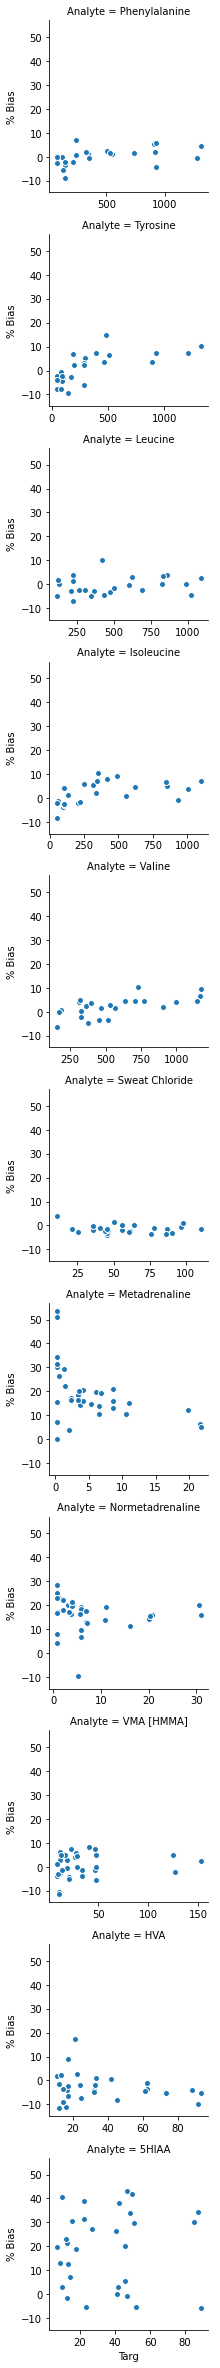

In [251]:
g = sns.FacetGrid(data=df,row='Analyte',sharex=False)
g = g.map(plt.scatter, "Targ", "% Bias", edgecolor="w")
g.add_legend()


In [162]:
standard_uncertainty = standard_uncertainty_data('EQA_analyte_information.csv')

df.merge(right=standard_uncertainty,on=['Analyte','Specimen','Scheme name'], how='inner')

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Analyte,Specimen,Pool,Result,Targ,Scheme name,Name,Value


### Standard uncertainty in the target value

In [159]:
def standard_uncertainty_data(filename):
    df = pd.read_csv(filename)
    standard_uncertainty = df[df['Name'] == 'Standard Uncertainty']
    
    #Assumes that there are three samples per distribution for all schemes
    standard_uncertainty['Distribution'][0::3] = standard_uncertainty['Distribution'][0::3].astype(str) + 'A'
    standard_uncertainty['Distribution'][1::3] = standard_uncertainty['Distribution'][1::3].astype(str) + 'B'
    standard_uncertainty['Distribution'][2::3] = standard_uncertainty['Distribution'][2::3].astype(str) + 'C'
    
    standard_uncertainty = standard_uncertainty.rename(columns={'Analyte name':'Analyte','Distribution':'Specimen'})
    
    return standard_uncertainty

In [160]:
standard_uncertainty_data('EQA_analyte_information.csv')

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nickf\Anaconda3\lib\site-packages\pandas\core\series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Name,Value,Analyte,Specimen,Scheme name
3,Standard Uncertainty,1.2,Initial TSH (mU/L WB),321A,Birmingham Quality ~ Newborn British Isles
13,Standard Uncertainty,1.1,Initial TSH (mU/L WB),321B,Birmingham Quality ~ Newborn British Isles
23,Standard Uncertainty,1.6,Initial TSH (mU/L WB),321C,Birmingham Quality ~ Newborn British Isles
33,Standard Uncertainty,0.8,Final TSH (mU/L WB),321A,Birmingham Quality ~ Newborn British Isles
43,Standard Uncertainty,0.7,Final TSH (mU/L WB),321B,Birmingham Quality ~ Newborn British Isles
53,Standard Uncertainty,1.0,Final TSH (mU/L WB),321C,Birmingham Quality ~ Newborn British Isles
63,Standard Uncertainty,0.7,Initial IRT (ng/mL [ug/L] WB),321A,Birmingham Quality ~ Newborn British Isles
73,Standard Uncertainty,1.2,Initial IRT (ng/mL [ug/L] WB),321B,Birmingham Quality ~ Newborn British Isles
83,Standard Uncertainty,2.1,Initial IRT (ng/mL [ug/L] WB),321C,Birmingham Quality ~ Newborn British Isles
93,Standard Uncertainty,0.6,Final IRT (ng/mL [ug/L] WB),321A,Birmingham Quality ~ Newborn British Isles


# Performance targets (*in progress*)

In [74]:
performance_targets[performance_targets['Assay'] == 'Amino acids (Plasma)']

,Assay,Measurand,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal
2,Amino acids (Plasma),Alanine,3.7,7.4,11.0,7.2,14.4,21.6,13.3,26.6,39.8
3,Amino acids (Plasma),Arginine,4.8,9.6,14.5,4.9,9.8,14.7,12.9,25.7,38.6
4,Amino acids (Plasma),Aspartic acid,7.8,15.6,23.4,7.9,15.8,23.7,20.8,41.6,62.4
5,Amino acids (Plasma),Citrulline,5.4,10.7,16.0,6.1,12.2,18.3,14.9,29.9,44.8
6,Amino acids (Plasma),Glutamic acid,11.6,23.2,34.8,11.5,23.1,34.6,30.7,61.4,92.1
7,Amino acids (Plasma),Glutamine,3.0,6.0,9.1,3.1,6.3,9.4,8.1,16.3,24.4
8,Amino acids (Plasma),Glycine,3.0,5.9,8.9,5.2,10.5,15.7,10.1,20.2,30.3
9,Amino acids (Plasma),Histidine,2.4,4.8,7.3,3.6,7.2,10.8,7.6,15.2,22.8
10,Amino acids (Plasma),Isoleucine,3.9,7.8,11.6,6.0,12.0,18.0,12.4,24.8,37.2
11,Amino acids (Plasma),Leucine,3.7,7.4,11.1,5.8,11.6,17.4,11.9,23.8,35.7


In [220]:
df_imprecision_added = df.merge(right=randoxMU,how='outer',on='Randox',copy=False)

In [221]:
pd.set_option('display.max_columns', 100)
df_imprecision_added

,Assay,Measurand,Randox,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal,Instrument,Lot Name,Count,Mean,UOM,% CV
0,Amino acids (CSF),Glycine,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
1,Amino acids (CSF),Serine,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
2,Amino acids (Urine),Alanine/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
3,Amino acids (Urine),Arginine/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
4,Amino acids (Urine),Aspartic acid/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
5,Amino acids (Urine),Citrulline/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
6,Amino acids (Urine),Cystine/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
7,Amino acids (Urine),Glutamic acid/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
8,Amino acids (Urine),Glutamine/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN
9,Amino acids (Urine),Glycine/creatinine ratio,NaN,5.00,10.0,15.00,5.000000,10.000000,15.00000,13.250000,26.500000,39.75000,NaN,NaN,NaN,NaN,NaN,NaN


### Import all QC data from Randox Acusera 24:7 (in progress)

The measurement uncertainty report provided by Randox Acusera 24:7 does not specify the time periods over which each lot number was used.

To find this information, export all data from Randox Acusera 24:7

****WHICH SECTION?****

and import to find the start and end dates for each lot number for each assay

In [ ]:
all_qc_data = pd.read_excel("Data Export 11-Nov-2020 to 11-Dec-2020.xlsx")
## Removes separator rows
all_qc_data = all_qc_data[all_qc_data['Assay'] != "Addenbrookes Hospital Biochemical Genetics Unit"]

In [ ]:
all_qc_data.head()

Find when each lot number was started or finished, for each essay

In [ ]:
Lot_numbers = all_qc_data.groupby(['Assay','Lot 1']).agg({'Date Time': [('Start date', 'min'), ('End date', 'max')]})

In [ ]:
Lot_numbers.head()